### 第五课 基于深度学习的chatbot

### 主要内容
* 更聪明的聊天机器人
  * 1.生成式模型 VS 检索匹配模型
  * 2.Chatterbot的进化：深度学习提高智能度
* 模型构建
  * 1.问题的分析与转化
  * 2.数据集与样本构造方法
  * 3.模型结构的构建
  * 4.模型的评估
  * 5.代码实现与解析

#### 基于检索的chatbot
*从知识库中找到最相近的问题/答案，前提是知识库有这样的问题(固定数据集找到合适内容去回答)
* 根据input和context，结合知识库的算法得到合适回复
* 从一个固定的数据集中找到合适的内容作为回复
* 检索和匹配的饿方式有很多种
* **数据和匹配方法对质量有很大影响**
* 优点：语法正确、速度快
* 缺点：缺少会话的概念、没有上下文改变

### 基于生成模型的chatbot
* **不仅仅可以从数据库中找到，还可以自己生成**
* 典型的是**seq2seq**的方法
* 生成的结果需要考虑通畅度和准确度
* 优点：结合上下文
* 缺点：通畅度不一定流利

以前者为主(可控度高)，后者为辅

深度学习发挥什么作用？
* 需要算法的地方就可以考虑深度学习的优势

### 回顾Chatterbot

机器人应答逻辑 --> Logic Adapters
* Closest Match dapter
  * 字符串模糊匹配(编辑距离)
* Closest Meaning Adapter
  * 借助nltk的WordNet，近义词评估
* Time Logic Adapter

但是应答模式的匹配方式太粗暴
* 编辑距离无法捕获深层语义信息
* 核心词+word2vec无法捕捉整句话语义
* LSTM等RNN模型能补货序列信息
* 用深度学习来提高匹配阶段准确率

### 应该怎么做
* 匹配本身是一个模糊的场景
  * 转成排序问题
* 排序问题怎么处理
  * 转成能输出概率的0-1分类问题
* 数据构建
  * 需要正样本(正确的回答)和负样本(不对的回答)

### 关于数据

* Ubuntu对话语料库--训练集

  * Ubuntu对话数据集，来自Ubuntu的IRC网络上的对话日志
  * 训练集1000000条实例，一半是正例（label为1），一半是负例（label为0，负例为随机生成）
  * 样本包括上下文信息(context，即Query)和一段可能的回复内容，即Response；**Label为1表示Response和Query的匹配，Label为0则表示不匹配**。
  * query的平均长度为86个word，而response的平均长度为17个word

* 验证/测试集：
  * 每个样本，有一个正例和九个负例数据(也称为干扰数据)
  * 建模的目标在于给正例的得分尽可能的高，而给负例的得分
尽可能的低。(有点类似分类任务)
  * 语料做过分词、stemmed、lemmatized等文本预处理。
  * 用NER(命名实体识别)将文本中的实体，如姓名、地点、组
织、URL等替换成特殊字符 


### 数据集查看

In [ ]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [ ]:
# Load Data
import csv
train_df = pd.read_csv("/content/drive/My Drive/chatBot/train (1).csv")
train_df.Label = train_df.Label.astype('category')

test_df = pd.read_csv("/content/drive/My Drive/chatBot/test.csv")
validation_df = pd.read_csv("/content/drive/My Drive/chatBot/valid.csv")

In [ ]:
train_df.describe()

,Context,Utterance,Label
count,1000000,1000000,1000000.0
unique,957130,744457,2.0
top,!ops __eou__ __eot__ ? __eou__ __eot__,thanks __eou__,0.0
freq,13,11024,500127.0


Text(0.5, 1.0, 'Training Label Distribution')

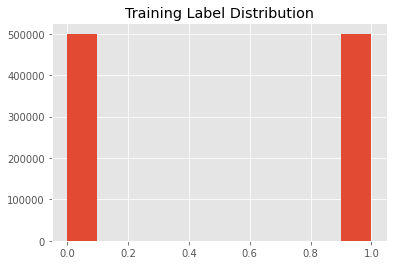

In [ ]:
train_df.Label.hist()
plt.title("Training Label Distribution")

In [ ]:
pd.options.display.max_colwidth = 500
train_df.head()

,Context,Utterance,Label
0,"i think we could import the old comments via rsync, but from there we need to go via email. I think it is easier than caching the status on each bug and than import bits here and there __eou__ __eot__ it would be very easy to keep a hash db of message-ids __eou__ sounds good __eou__ __eot__ ok __eou__ perhaps we can ship an ad-hoc apt_prefereces __eou__ __eot__ version? __eou__ __eot__ thanks __eou__ __eot__ not yet __eou__ it is covered by your insurance? __eou__ __eot__ yes __eou__ but it...",basically each xfree86 upload will NOT force users to upgrade 100Mb of fonts for nothing __eou__ no something i did in my spare time. __eou__,1.0
1,"I'm not suggesting all - only the ones you modify. __eou__ __eot__ ok, it sounds like you're agreeing with me, then __eou__ though rather than ""the ones we modify"", my idea is ""the ones we need to merge"" __eou__ __eot__",sorry __eou__ i thought it was ubuntu related. __eou__,0.0
2,"afternoon all __eou__ not entirely related to warty, but if grub-install takes 5 minutes to install, is this a sign that i should just retry the install :) __eou__ __eot__ here __eou__ __eot__ you might want to know that thinice in warty is buggy compared to that in sid __eou__ __eot__ and apparently GNOME is suddently almost perfect (out of the thinice problem), nobody report bugs :-P __eou__ I don't get your question, where do you want to paste ? __eou__ __eot__ can i file the panel not l...","Yep. __eou__ oh, okay. I wondered what happened to you __eou__ what distro do you need? __eou__ yes __eou__",0.0
3,"interesting __eou__ grub-install worked with / being ext3, failed when it was xfs __eou__ i thought d-i installed the relevant kernel for your machine. i have a p4 and its installed the 386 kernel __eou__ holy crap a lot of stuff gets installed by default :) __eou__ YOU ARE INSTALLING VIM ON A BOX OF MINE __eou__ ;) __eou__ __eot__ more like osx than debian ;) __eou__ we have a selection of python modules available for great justice (and python development) __eou__ __eot__ 2.8 is fixing them...",thats the one __eou__,1.0
4,"and because Python gives Mark a woody __eou__ __eot__ i'm not sure if we're meant to talk about that publically yet. __eou__ __eot__ and I thought we were a ""pants off"" kind of company ... :p __eou__ you need new glasses __eou__ __eot__ mono 1.0? dude, that's going to be a barrel of laughs for totally non-release related reasons during hoary __eou__ read bryan clark's entry about NetworkManager? __eou__ __eot__ there was an accompanying IRC conversation to that one <g> __eou__ explain ? __eo...",(i thought someone was going to make a joke about .au bandwidth...) __eou__ especially not if you're using screen ;) __eou__,1.0


count    1000000.000000
mean          77.877830
std           66.837906
min            7.000000
25%           34.000000
50%           57.000000
75%           97.000000
max         2034.000000
Name: Context, dtype: float64


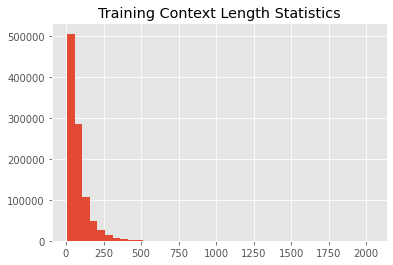

In [ ]:
plt.figure(1)
train_df_context_len = train_df.Context.str.split(" ").apply(len)
train_df_context_len.hist(bins=40)
# 训练样本中问题长度的分布，主要接种在0-100之间
plt.title("Training Context Length Statistics")
print(train_df_context_len.describe())

count    1000000.000000
mean          15.204147
std           14.642695
min            2.000000
25%            6.000000
50%           11.000000
75%           20.000000
max          584.000000
Name: Utterance, dtype: float64


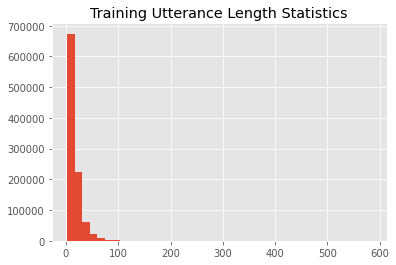

In [ ]:
plt.figure(2)
train_df_utterance_len = train_df.Utterance.str.split(" ").apply(len)
train_df_utterance_len.hist(bins=40)
#训练样本中回答的问题长度的分布，主要接种在0-20之间
plt.title("Training Utterance Length Statistics")
print(train_df_utterance_len.describe())

In [ ]:
pd.options.display.max_colwidth = 500
# 测试集的分布，context表示提问的问题，Ground Truth utterance表示问题的正确答案，Distractor表示9个负倒样本
test_df.head()

,Context,Ground Truth Utterance,Distractor_0,Distractor_1,Distractor_2,Distractor_3,Distractor_4,Distractor_5,Distractor_6,Distractor_7,Distractor_8
0,"anyone knows why my stock oneiric exports env var 'USERNAME'? I mean what is that used for? I know of $USER but not $USERNAME . My precise install doesn't export USERNAME __eou__ __eot__ looks like it used to be exported by lightdm, but the line had the comment ""// FIXME: Is this required?"" so I guess it isn't surprising it is gone __eou__ __eot__ thanks! How the heck did you figure that out? __eou__ __eot__ https://bugs.launchpad.net/lightdm/+bug/864109/comments/3 __eou__ __eot__",nice thanks! __eou__,"wrong channel for it, but check efnet.org, unofficial page. __eou__","every time the kernel changes, you will lose video __eou__ yep __eou__",ok __eou__,!nomodeset > acer __eou__ I'm assuming it is a driver issue. __eou__ !pm > acer __eou__ i DON'T pm. ;) __eou__ OOPS SORRY FOR THE CAPS __eou__,"http://www.ubuntu.com/project/about-ubuntu/derivatives (some call them derivatives, others call them flavors, same difference) __eou__",thx __eou__ unfortunately the program isn't installed from the repositories __eou__,how can I check? By doing a recovery for testing? __eou__,my humble apologies __eou__,#ubuntu-offtopic __eou__
1,"i set up my hd such that i have to type a passphrase to access it at boot. how can i remove that passwrd, and just boot up normal. i did this at install, it works fine, just tired of having reboots where i need to be at terminal to type passwd in. help? __eou__ __eot__ backup your data, and re-install without encryption ""might"" be the easiest method __eou__ __eot__","so you dont know, ok, anyone else? __eou__ you are like, yah my mouse doesnt work, reinstall your os lolol what a joke __eou__","nmap is nice, but it wasn't what I was looking for. I finally found it again: mtr (my traceroute) is what I was looking for. I'll be keeping nmap handy though. __eou__",ok __eou__,"cdrom worked fine on windows. __eou__ i dont think it has anything to do with the buring process, cds work fine on my desktop and my other ubuntu lap __eou__","ah yes, i have read return as rerun __eou__",hm? __eou__,"not the case, LTS is every other .04 release. The .04 isn't always more stable __eou__ I would reinstall with Precise __eou__ you can restore user data and such from backup __eou__",Pretty much __eou__,I used the one I downloaded from AMD __eou__,"ffmpeg is part of the package , quixotedon , at least I'm quite sure it still is __eou__ if not just install ffmpeg __eou__"
2,im trying to use ubuntu on my macbook pro retina __eou__ i read in the forums that ubuntu has a apple version now? __eou__ __eot__ not that ive ever heard of.. normal ubutnu should work on an intel based mac. there is the PPC version also. __eou__ you want total control? or what are you wanting exactly? __eou__ __eot__,just wondering how it runs __eou__,"yes, that's what I did, exported it to a ""id_dsa"" file, then back to Ubuntu copied it into ~/.ssh/ __eou__",nothing - i am talking about the question of myhero __eou__,that should fix the fonts being too large __eou__,"okay, so hcitool echos back hci0 <mac address of controller> but the bluetooth devices panel keeps disconnecting and reconnecting the device (or so it seems) any idea why that would be? __eou__","I get to the menu with options such as 'try ubuntu', 'install ubuntu', 'check disc' __eou__","why do u need analyzer __eou__ it is a toy __eou__ ok msp301 __eou__ but y, i mean it is the same ubunut, only with older programs __eou__ ubuntu 804 or 1204 __eou__ no i dont use 804 __eou__ i am asking hypo qs __eou__",Cntrl-C may stop the command but it doesn't fix my HDD problem. __eou__,"if you're only going to run Ubuntu, just get a normal PC rather than a mac __eou__ that said, I'm running it on a macbook, because I got one relatively cheaply __eou__",the ones which are not picked up at the moment are on STDERR and not STDOUT and > is only covering S

In [ ]:
test_df.describe()

,Context,Ground Truth Utterance,Distractor_0,Distractor_1,Distractor_2,Distractor_3,Distractor_4,Distractor_5,Distractor_6,Distractor_7,Distractor_8
count,18920,18920,18920,18920,18920,18920,18920,18920,18920,18920,18920
unique,18920,18026,14066,13998,14162,14116,14200,14149,14064,14068,14202
top,"howto fix a corrupt square mouse pointer every cold boot in precise?(ati grafix card) __eou__ __eot__ were you here yesterday or so with same problem ? __eou__ did you try restarting x ? __eou__ sudo service login-manager restart __eou__ probably not __eou__ however if restrting x makes it go away then there may be a setting in your x config to fix it __eou__ __eot__ whats up mate __eou__ i got the square mouse away, but compiz doesnt run anymore __eou__ __eot__ nada raping a ftp server with...",thanks __eou__,thanks __eou__,thanks __eou__,thanks __eou__,thanks __eou__,thanks __eou__,thanks __eou__,thanks __eou__,thanks __eou__,thanks __eou__
freq,1,152,133,142,163,148,130,164,155,151,156


### 基线模型：random guess 
* 评估y中前K个后选中是否存在正确的标签，存在则count++，统计

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
# Load Data
train_df = pd.read_csv("/content/drive/My Drive/chatBot/train (1).csv")
test_df = pd.read_csv("/content/drive/My Drive/chatBot/test.csv")
validation_df = pd.read_csv("/content/drive/My Drive/chatBot/valid.csv")

In [ ]:
y_test = np.zeros(len(test_df))
y_test

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
def evaluate_recall(y, y_test, k=1):
    num_examples = float(len(y))
    num_correct = 0
    for predictions, label in zip(y, y_test):
        if label in predictions[:k]:#评估y中前K个后选中是否存在正确的标签，存在则count++，统计
            num_correct += 1
    return num_correct/num_examples

In [ ]:
def predict_random(context, utterances):
    return np.random.choice(len(utterances), 10, replace=False)

In [ ]:
# Evaluate Random predictor
y_random = [predict_random(test_df.Context[x], test_df.iloc[x,1:].values) for x in range(len(test_df))]
for n in [1, 2, 5, 10]:
    print("Recall @ ({}, 10): {:g}".format(n, evaluate_recall(y_random, y_test, n)))

Recall @ (1, 10): 0.0986786
Recall @ (2, 10): 0.199313
Recall @ (5, 10): 0.497093
Recall @ (10, 10): 1


### 基线模型：TF-IDF检索

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

class TFIDFPredictor:
    def __init__(self):
        self.vectorizer = TfidfVectorizer()

    def train(self, data):
        self.vectorizer.fit(np.append(data.Context.values,data.Utterance.values))

    def predict(self, context, utterances):
        # Convert context and utterances into tfidf vector
        vector_context = self.vectorizer.transform([context])
        vector_doc = self.vectorizer.transform(utterances)
        # The dot product measures the similarity of the resulting vectors
        result = np.dot(vector_doc, vector_context.T).todense()
        result = np.asarray(result).flatten()
        # Sort by top results and return the indices in descending order
        return np.argsort(result, axis=0)[::-1]

In [ ]:
# Evaluate TFIDF predictor
pred = TFIDFPredictor()
pred.train(train_df)
y = [pred.predict(test_df.Context[x], test_df.iloc[x,1:].values) for x in range(len(test_df))]
for n in [1, 2, 5, 10]:
    print("Recall @ ({}, 10): {:g}".format(n, evaluate_recall(y, y_test, n)))

Recall @ (1, 10): 0.485624
Recall @ (2, 10): 0.586681
Recall @ (5, 10): 0.762474
Recall @ (10, 10): 1


### example
* seklearn总对于CounterVectorizer、TfidfTransformer、TfidfVectorizer的理解
* https://blog.csdn.net/m0_37324740/article/details/79411651
* https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
 
vectorizer = CountVectorizer(min_df=1)
 
corpus = [
        'This is the first document.',
    		'This is the second second document.',
    		'And the third one.',
		    'Is this the first document?',
		]
X = vectorizer.fit_transform(corpus)
feature_name = vectorizer.get_feature_names()

In [ ]:
print(feature_name)#获取词袋模型文本的所有关键字
print("\n")
print(X.toarray())#看到词频矩阵
print("\n")
print(X)#举证中出现则+1，否则为0

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


[[0 1 1 1 0 0 1 0 1]
 [0 1 0 1 0 2 1 0 1]
 [1 0 0 0 1 0 1 1 0]
 [0 1 1 1 0 0 1 0 1]]


  (0, 8)	1
  (0, 3)	1
  (0, 6)	1
  (0, 2)	1
  (0, 1)	1
  (1, 8)	1
  (1, 3)	1
  (1, 6)	1
  (1, 1)	1
  (1, 5)	2
  (2, 6)	1
  (2, 0)	1
  (2, 7)	1
  (2, 4)	1
  (3, 8)	1
  (3, 3)	1
  (3, 6)	1
  (3, 2)	1
  (3, 1)	1


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer 
 
 
corpus = [
    'This is the first document.',
		'This is the second second document.',
		'And the third one.',
		'Is this the first document?',
		]
 
vectorizer=CountVectorizer()
 
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(corpus)) 
print (tfidf)

  (0, 8)	0.4387767428592343
  (0, 6)	0.35872873824808993
  (0, 3)	0.4387767428592343
  (0, 2)	0.5419765697264572
  (0, 1)	0.4387767428592343
  (1, 8)	0.2723014675233404
  (1, 6)	0.22262429232510395
  (1, 5)	0.8532257361452786
  (1, 3)	0.2723014675233404
  (1, 1)	0.2723014675233404
  (2, 7)	0.5528053199908667
  (2, 6)	0.2884767487500274
  (2, 4)	0.5528053199908667
  (2, 0)	0.5528053199908667
  (3, 8)	0.4387767428592343
  (3, 6)	0.35872873824808993
  (3, 3)	0.4387767428592343
  (3, 2)	0.5419765697264572
  (3, 1)	0.4387767428592343


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf2 = TfidfVectorizer()
re = tfidf2.fit_transform(corpus)
print (re)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf2 = TfidfVectorizer()
re = tfidf2.fit_transform(corpus)
print (re)

  (0, 1)	0.4387767428592343
  (0, 2)	0.5419765697264572
  (0, 6)	0.35872873824808993
  (0, 3)	0.4387767428592343
  (0, 8)	0.4387767428592343
  (1, 5)	0.8532257361452786
  (1, 1)	0.2723014675233404
  (1, 6)	0.22262429232510395
  (1, 3)	0.2723014675233404
  (1, 8)	0.2723014675233404
  (2, 4)	0.5528053199908667
  (2, 7)	0.5528053199908667
  (2, 0)	0.5528053199908667
  (2, 6)	0.2884767487500274
  (3, 1)	0.4387767428592343
  (3, 2)	0.5419765697264572
  (3, 6)	0.35872873824808993
  (3, 3)	0.4387767428592343
  (3, 8)	0.4387767428592343


### 神经网络建模

代码参考文件

In [4]:
cd /content/drive/My Drive

/content/drive/My Drive


In [5]:
ls

 bot/       chatbot-retrieval/   datasets/   temp/   xiamen/
 chatBot/  'Colab Notebooks'/    HUAWEI/     VQA/    入职文件.zip


In [ ]:
#!git clone https://github.com/dennybritz/chatbot-retrieval

Cloning into 'chatbot-retrieval'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 392 (delta 0), reused 0 (delta 0), pack-reused 389
Receiving objects: 100% (392/392), 19.63 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [6]:
cd chatbot-retrieval/

/content/drive/My Drive/chatbot-retrieval


In [7]:
ls

data/    notebooks/    requirements.txt  udc_inputs.py   udc_predict.py
LICENSE  __pycache__/  scripts/          udc_metrics.py  udc_test.py
models/  README.md     udc_hparams.py    udc_model.py    udc_train.py


In [14]:
!python udc_train.py



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0828 09:46:21.833918 139745635493760 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
W0828 09:46:21.834181 139745635493760 deprecation.py:323] From udc_train.py:40: RunConfig.__init__ (from te

In [13]:
# %tensorflow_version 1.15.2
# import tensorflow as tf
# tf.__version__

'1.15.2'

In [ ]:
!python udc_test.py --model_dir=...

In [ ]:
!python udc_predict.py --model_dir=...